# Reinforcement Learning - DDQN

Matías Echeverría

## Setup

In [1]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH > /dev/null omits command output
!python -m atari_py.import_roms 'ROMS' > /dev/null

--2021-06-30 13:17:10--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  10.61M   481KB/s    in 23s     

2021-06-30 13:17:34 (467 KB/s) - ‘Roms.rar.1’ saved [11128004/11128004]



Would you like to replace the existing file HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit q
replace ROMS/128 in 1 Game Select ROM (128 in 1) (Unknown) ~.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


#### Preprocessing

In [2]:
import gym
import cv2
import numpy as np

def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

In [3]:
from collections import deque
import random

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """
        Saves experiences in the form of (state, action, next_state, reward, done)
        """
        assert len(args) == 5, "Must have 5 arguments"
        self.memory.append([i for i in args])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)

        state, action, next_state, reward, done = [], [], [], [], []

        for s, a, n_s, r, d in batch:
            state.append(s)
            action.append(a)
            next_state.append(n_s)
            reward.append(r)
            done.append(d)

        state      = np.array(state,      dtype=np.float32) / 255.0
        action     = np.array(action,     dtype=np.int64)
        next_state = np.array(next_state, dtype=np.float32) / 255.0
        reward     = np.array(reward,     dtype=np.int8)
        done       = np.array(done,       dtype=np.int8)

        return (state, action, next_state, reward, done)

    def __len__(self):
        return len(self.memory)

Let's see how it looks so far

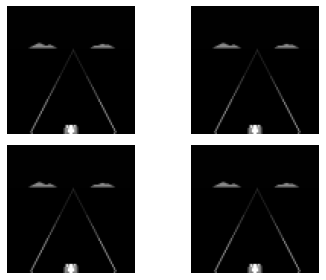

(4, 84, 84)
(4, 84, 84)


In [4]:
from gym.wrappers import FrameStack
import matplotlib.pyplot as plt

game = 'Enduro-v0'
env = gym.make(game, frameskip=4)

seed = 0
env.seed(seed)
obs = env.reset()

env = ProcessFrame84(env)
env = FrameStack(env,num_stack=4)
obs = env.reset()



plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print(obs.shape)
print(np.array(obs).shape)

## Dueling DQN & DQN

In [5]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        # forward pass red convolucional
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        # forward pass rama fully-connected para V(s)
        val = self.relu(self.fc1_val(x))
        val = self.fc2_val(val).expand(x.size(0), self.num_actions)
        # forward pass rama fully-connected para A(s,a)
        adv = self.relu(self.fc1_adv(x))
        adv = self.fc2_adv(adv)

        # Calculo de Q(s,a) a partir de ecuacion (4)
        Q_values = val + adv - adv.mean(1).unsqueeze(1).expand(x.size(0), self.num_actions)

        return Q_values

class DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Hyperparameters

In [7]:
import torch.optim as optim

# Hyperparametros (obtenidos del paper del enunciado)
replay_buffer_size=500_000
batch_size = 32
gamma = 0.99 # Discounted return
learning_starts = 50_000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se ejecuta una propagación error (loss) en la red
frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
target_update_freq=10_000 # Frecuencia en que se actualizan los pesos de la red target
LR = 0.00025 # Tasa de aprendizaje

LOG_EVERY_N_STEPS = 50_000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250_000 # Pasos por época
N_EPOCHS = 20 # Número de épocas (bajo a 15, no me echa y tengo buenos resultados)

In [9]:
def exploration(t):
    """
    e-greedy policy
    """
    if t >= 1_000_000:
        return 0.1
    return -(0.9 / 1_000_000) * t + 1

  0%|          | 25/250000 [00:00<16:41, 249.50it/s]


(1) Epoch Average: 0.0 | Epoch Max: 0



  0%|          | 25/250000 [00:00<18:26, 225.89it/s]


(2) Epoch Average: 0.0 | Epoch Max: 0



  0%|          | 21/250000 [00:00<20:08, 206.90it/s]


(3) Epoch Average: 0.2 | Epoch Max: 2.0



  0%|          | 20/250000 [00:00<21:17, 195.69it/s]


(4) Epoch Average: 45.36 | Epoch Max: 122.0



  0%|          | 21/250000 [00:00<20:36, 202.09it/s]


(5) Epoch Average: 194.51470588235293 | Epoch Max: 514.0



  0%|          | 21/250000 [00:00<20:46, 200.55it/s]


(6) Epoch Average: 466.0731707317073 | Epoch Max: 592.0



  0%|          | 21/250000 [00:00<21:49, 190.84it/s]


(7) Epoch Average: 582.0285714285715 | Epoch Max: 981.0



  0%|          | 19/250000 [00:00<22:04, 188.80it/s]


(8) Epoch Average: 533.027027027027 | Epoch Max: 887.0



  0%|          | 21/250000 [00:00<21:05, 197.57it/s]


(9) Epoch Average: 542.5945945945946 | Epoch Max: 903.0



  0%|          | 21/250000 [00:00<22:06, 188.48it/s]


(10) Epoch Average: 545.7297297297297 | Epoch Max: 865.0



  0%|          | 21/250000 [00:00<20:32, 202.88it/s]


(11) Epoch Average: 644.34375 | Epoch Max: 877.0



  0%|          | 21/250000 [00:00<22:43, 183.34it/s]


(12) Epoch Average: 549.2972972972973 | Epoch Max: 963.0



  0%|          | 21/250000 [00:00<21:38, 192.57it/s]


(13) Epoch Average: 559.8888888888889 | Epoch Max: 907.0



  0%|          | 21/250000 [00:00<21:27, 194.18it/s]


(14) Epoch Average: 540.2162162162163 | Epoch Max: 923.0



  0%|          | 21/250000 [00:00<21:42, 191.93it/s]


(15) Epoch Average: 551.8333333333334 | Epoch Max: 898.0



  0%|          | 21/250000 [00:00<21:37, 192.66it/s]


(16) Epoch Average: 507.43589743589746 | Epoch Max: 912.0



  0%|          | 21/250000 [00:00<22:33, 184.64it/s]


(17) Epoch Average: 520.8974358974359 | Epoch Max: 904.0



  0%|          | 21/250000 [00:00<20:17, 205.35it/s]


(18) Epoch Average: 549.2702702702703 | Epoch Max: 936.0



  0%|          | 21/250000 [00:00<19:54, 209.22it/s]


(19) Epoch Average: 563.8888888888889 | Epoch Max: 938.0



100%|██████████| 20/20 [6:16:06<00:00, 1128.32s/it]



(20) Epoch Average: 484.0243902439024 | Epoch Max: 596.0



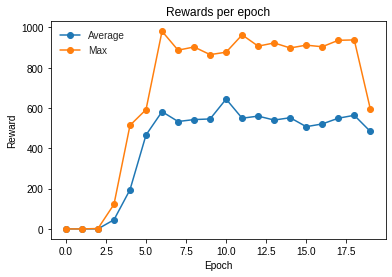

In [10]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device)
Q_target = Dueling_DQN(in_channels, num_actions).to(device)

optimizer = torch.optim.RMSprop(Q.parameters(), lr=LR)
criterion = nn.MSELoss()

replay_memory = ReplayMemory(replay_buffer_size)

last_obs = env.reset()
count = 0

data = {
    'avg': [],
    'max': []
}

for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
    episode_rewards = deque(maxlen=100)
    reward_acc = 0

    for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
        #1. before learning starts, choose actions randomly
        if count < learning_starts:
            action = np.random.randint(num_actions)
        else:
            # epsilon greedy exploration
            sample = random.random()
            threshold = exploration(count) 
            if sample > threshold:
                with torch.no_grad():
                    obs = torch.from_numpy(np.array(obs, dtype=np.float32) / 255.0).unsqueeze(0).to(device)
                    action = int(torch.argmax(Q(obs), dim=1).item())
            else:
                action = np.random.randint(num_actions)

        obs, reward, done, info = env.step(action)
        reward_acc += max(0, reward)
      
        replay_memory.push(last_obs, action, obs, reward, done)
        if done:
            obs = env.reset()
            episode_rewards.append(reward_acc)
            reward_acc = 0

        # update last_obs
        last_obs = obs

        ### 2. Perform experience replay and train the network.
        if (count > learning_starts and t % learning_freq == 0):
            obs_t, act_t, next_obs, rew_t, done_mask = replay_memory.sample(32)
          
            obs_t = torch.from_numpy(obs_t).to(device)
            act_t = torch.from_numpy(act_t).to(device)
            rew_t = torch.from_numpy(rew_t).to(device)
            next_obs = torch.from_numpy(next_obs).to(device)
            done_mask = torch.from_numpy(done_mask).to(device)

            # input batches to networks
            next_q = Q_target(next_obs)
            max_next_q = torch.max(next_q, 1)[0]
            y = rew_t + (1 - done_mask) * gamma * max_next_q

            # Loss calculation
            last_q = Q(obs_t)
            x = last_q.gather(1, act_t.unsqueeze(1)).squeeze(1)
            
            loss = criterion(x, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if t % target_update_freq == 0:
                Q_target.load_state_dict(Q.state_dict())

        count += 1

    """
    Save model after every epoch
    """
    torch.save(Q.state_dict(), path + 'model.pth')
    epoch_avg = sum(episode_rewards)/len(episode_rewards)
    epoch_max = max(episode_rewards)
    print("\n({}) Epoch Average: {} | Epoch Max: {}\n".format(epoch+1, epoch_avg, epoch_max))
    data['avg'].append(epoch_avg)
    data['max'].append(epoch_max)

fig, ax = plt.subplots()
plt.style.use('seaborn-white')
plt.plot(data['avg'], marker='o')
plt.plot(data['max'], marker='o')
plt.legend(['Average', 'Max'])
plt.title('Rewards per epoch')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.show()

# Test

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Q = Dueling_DQN(in_channels, num_actions)
Q.load_state_dict(torch.load('model.pth'))
Q.to(device)

done = 0
last_obs = env.reset()
frames = []
r = 0
while not done:
    frames.append(last_obs[0])
    obs = torch.from_numpy(np.array(last_obs, dtype=np.float32) / 255.0).unsqueeze(0).to(device)
    action = int(torch.argmax(Q(obs), dim=1).item())
    obs, reward, done, info = env.step(action)
    r += reward
    last_obs = obs

print(len(frames))
print(r)

10000
801.0


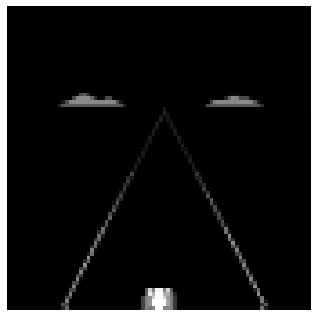

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[:500]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())